In [5]:
import pandas as pd
import numpy as np
import keras as k
from keras.models import Sequential
from keras.layers import  Conv2D, MaxPool2D, Dropout, Dense, Flatten
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import SGD

import os

Using TensorFlow backend.


In [0]:
zip_dir = k.utils.get_file('cats_and_dogs_filterted.zip', origin='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', extract=True)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [0]:
batch_size = 150
image_size = 150

train_image_generator = k.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                 rotation_range = 40,
                                                                 width_shift_range = 0.2,
                                                                 height_shift_range = 0.2,
                                                                 shear_range = 0.2,
                                                                 zoom_range = 0.5,
                                                                 horizontal_flip = True,
                                                                 fill_mode = 'nearest')
validation_image_generator = k.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_data_generator = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                                      directory = train_dir,
                                                                      shuffle = True, 
                                                                      target_size = [image_size, image_size],
                                                                      class_mode = 'binary')

validation_data_generator = validation_image_generator.flow_from_directory(batch_size = batch_size,
                                                                      directory = validation_dir,
                                                                      shuffle = True, 
                                                                      target_size = [image_size, image_size],
                                                                      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation= 'relu', input_shape = (150, 150, 3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation= 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, (3,3), activation= 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, (3,3), activation= 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [0]:
epochs = 10
history = model.fit_generator(train_data_generator,
                              epochs = epochs,
                              steps_per_epoch= 20,
                              validation_data = validation_data_generator, validation_steps = 10)

Epoch 1/10
20/20 [==============================] - 26s 1s/step - loss: 0.3926 - acc: 0.8191 - val_loss: 0.3859 - val_acc: 0.8229
Epoch 2/10
20/20 [==============================] - 26s 1s/step - loss: 0.3800 - acc: 0.8283 - val_loss: 0.3751 - val_acc: 0.8303
Epoch 3/10
20/20 [==============================] - 25s 1s/step - loss: 0.3571 - acc: 0.8379 - val_loss: 0.4168 - val_acc: 0.8214
Epoch 4/10
20/20 [==============================] - 26s 1s/step - loss: 0.3918 - acc: 0.8177 - val_loss: 0.4168 - val_acc: 0.8034
Epoch 5/10
20/20 [==============================] - 26s 1s/step - loss: 0.3954 - acc: 0.8183 - val_loss: 0.3846 - val_acc: 0.8186
Epoch 6/10
20/20 [==============================] - 25s 1s/step - loss: 0.3887 - acc: 0.8310 - val_loss: 0.3971 - val_acc: 0.8179
Epoch 7/10
20/20 [==============================] - 26s 1s/step - loss: 0.3505 - acc: 0.8429 - val_loss: 0.3849 - val_acc: 0.8166
Epoch 8/10
20/20 [==============================] - 25s 1s/step - loss: 0.3596 - acc: 0.84

In [0]:
#let's try fine tuning
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (150,150,3))
for layer in base_model.layers:
  layer.trainable = False
flat1 = Flatten()(base_model.layers[-1].output)
drop1 = Dropout(0.5)(flat1)
class1 = Dense(128, activation = 'relu', kernel_initializer='he_uniform')(drop1)
output = Dense(2, activation = 'softmax')(class1)

model = Model(inputs = base_model.inputs, outputs = output)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

epochs = 20
history = model.fit_generator(train_data_generator,
                              epochs = epochs,
                              steps_per_epoch= 40,
                              validation_data = validation_data_generator, validation_steps = 10)

Epoch 1/20
40/40 [==============================] - 64s 2s/step - loss: 0.8871 - acc: 0.5435 - val_loss: 0.6089 - val_acc: 0.8103
Epoch 2/20
40/40 [==============================] - 56s 1s/step - loss: 0.5640 - acc: 0.7284 - val_loss: 0.3751 - val_acc: 0.8243
Epoch 3/20
40/40 [==============================] - 56s 1s/step - loss: 0.4647 - acc: 0.7785 - val_loss: 0.3193 - val_acc: 0.8607
Epoch 4/20
40/40 [==============================] - 55s 1s/step - loss: 0.4230 - acc: 0.8026 - val_loss: 0.2810 - val_acc: 0.8814
Epoch 5/20
40/40 [==============================] - 57s 1s/step - loss: 0.4069 - acc: 0.8117 - val_loss: 0.2802 - val_acc: 0.8800
Epoch 6/20
40/40 [==============================] - 55s 1s/step - loss: 0.4098 - acc: 0.8111 - val_loss: 0.2808 - val_acc: 0.8757
Epoch 7/20
40/40 [==============================] - 55s 1s/step - loss: 0.4134 - acc: 0.8065 - val_loss: 0.2672 - val_acc: 0.8800
Epoch 8/20
40/40 [==============================] - 55s 1s/step - loss: 0.4022 - acc: 0.81

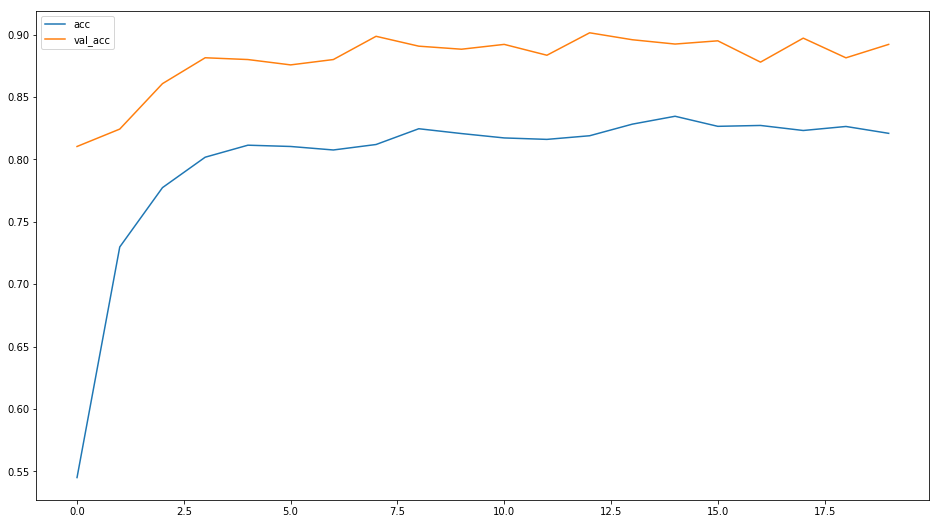

In [0]:
plt.figure(figsize=(16,9))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

In [0]:
#save model with weights
model.save('CatDog.h5')